# Capstone Project Final - Week 5

Let's start by importing our variables:

In [31]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np


Cast the data prepared on my csv file as a dataframe

In [23]:
mex_data = pd.read_csv('mex_data2.csv')
mex_data[["Latitude", "Longitude"]] = mex_data[["Latitude", "Longitude"]].apply(pd.to_numeric)
mex_data

,Borough,Avg-HousePrice,Latitude,Longitude
0,Álvaro Obregón,"10,676.65",19.3605,-99.2267
1,Azcapotzalco,"13,828.76",19.4847,-99.1887
2,Benito Juárez,"35,961.82",19.3794,-99.1591
3,Coyoacán,"19,142.35",19.3487,-99.1629
4,Cuajimalpa,"5,913.82",19.3558,-99.2994
5,Cuauhtémoc,"40,069.73",19.4356,-99.1495
6,Gustavo A. Madero,"17,980.86",19.4873,-99.1236
7,Iztacalco,"40,000.00",19.3948,-99.0977
8,Iztapalapa,"14,657.94",19.3421,-99.0532
9,Magdalena Contreras,"6,500.00",19.3150,-99.2426


Lets create a map to visualize the location of each borough

In [25]:
map_mex = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough in zip(mex_data['Latitude'], mex_data['Longitude'], mex_data['Borough'],):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
       [lat, lng],
       radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
    parse_html=False).add_to(map_mex)  
    

map_mex

We use Foursquare API to generate a list of venues per borough:

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

mex_venues = getNearbyVenues(names=mex_data['Borough'], latitudes=mex_data['Latitude'], longitudes=mex_data['Longitude'])

mex_venues.head()

Álvaro Obregón
Azcapotzalco
Benito Juárez
Coyoacán
Cuajimalpa
Cuauhtémoc
Gustavo A. Madero
Iztacalco
Iztapalapa
Magdalena Contreras
Miguel Hidalgo
Tlahuac
Tlalpan
Venustiano Carranza
Xochimilco


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Álvaro Obregón,19.3605,-99.2267,Farmacia San Pablo,19.361123,-99.227062,Pharmacy
1,Álvaro Obregón,19.3605,-99.2267,Pizzeria Comemos Pizza,19.360420,-99.228200,Pizza Place
2,Álvaro Obregón,19.3605,-99.2267,Office Depot,19.362531,-99.223872,Electronics Store
3,Álvaro Obregón,19.3605,-99.2267,Starbucks,19.362252,-99.224099,Coffee Shop
4,Álvaro Obregón,19.3605,-99.2267,Ricas Tortas Gigantes El Toxi,19.362232,-99.224350,Burger Joint


Lets create a dataframe to generate table of counts of venue per borough and plot it on a bar chart:

In [28]:
df = mex_venues.groupby('Borough')['Venue'].count().reset_index()
df

,Borough,Venue
0,Azcapotzalco,23
1,Benito Juárez,45
2,Coyoacán,100
3,Cuajimalpa,26
4,Cuauhtémoc,90
5,Gustavo A. Madero,52
6,Iztacalco,25
7,Iztapalapa,12
8,Magdalena Contreras,11
9,Miguel Hidalgo,100


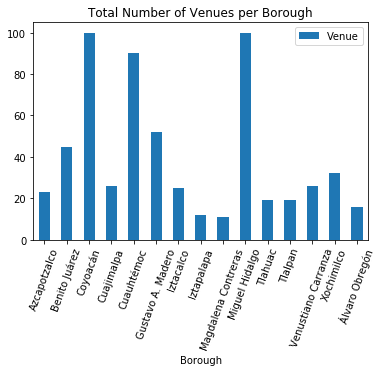

In [30]:
df.plot.bar(x="Borough", y="Venue", rot=70, title="Total Number of Venues per Borough");

plt.show(block=True)

Let's generate a table of the top 10 most common venues per borough:

In [32]:
# one hot encoding
mex_onehot = pd.get_dummies(mex_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mex_onehot['Borough'] = mex_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [mex_onehot.columns[-1]] + list(mex_onehot.columns[:-1])
mex_onehot = mex_onehot[fixed_columns]

mex_grouped = mex_onehot.groupby('Borough').mean().reset_index()

num_top_venues = 10

for hood in mex_grouped['Borough']:
   # print("----"+hood+"----")
    temp = mex_grouped[mex_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
  #  print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
  #  print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = mex_grouped['Borough']

for ind in np.arange(mex_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mex_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Azcapotzalco,Mexican Restaurant,Bakery,Seafood Restaurant,Shopping Mall,Lounge,Breakfast Spot,Farmers Market,Ice Cream Shop,Burrito Place,Motel
1,Benito Juárez,Mexican Restaurant,Pizza Place,Coffee Shop,Taco Place,Sushi Restaurant,Drugstore,Russian Restaurant,Restaurant,Burrito Place,IT Services
2,Coyoacán,Mexican Restaurant,Ice Cream Shop,Bar,Coffee Shop,Café,Plaza,Art Gallery,Bookstore,Italian Restaurant,Market
3,Cuajimalpa,Pizza Place,Taco Place,Bakery,Burger Joint,Gym,Soccer Field,Convenience Store,New American Restaurant,Dance Studio,Park
4,Cuauhtémoc,Mexican Restaurant,Hotel,Taco Place,Bar,Restaurant,Coffee Shop,Art Museum,Pizza Place,Argentinian Restaurant,Building


Let's use K-means algorithm for clustering the data

In [33]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

mex_grouped_clustering = mex_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mex_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mex_merged = mex_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mex_merged = mex_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

mex_merged

Lets explore each cluster to find common characteristics:

In [16]:
mex_merged.loc[mex_merged['Cluster Labels'] == 0, mex_merged.columns[[1] + list(range(5, mex_merged.shape[1]))]]

,Avg-HousePrice,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"13,828.76",Mexican Restaurant,Bakery,Seafood Restaurant,Shopping Mall,Lounge,Breakfast Spot,Farmers Market,Ice Cream Shop,Burrito Place,Motel
2,"35,961.82",Mexican Restaurant,Pizza Place,Coffee Shop,Taco Place,Sushi Restaurant,Drugstore,Russian Restaurant,Restaurant,Burrito Place,IT Services
3,"19,142.35",Mexican Restaurant,Ice Cream Shop,Bar,Coffee Shop,Café,Plaza,Art Gallery,Bookstore,Italian Restaurant,Market
5,"40,069.73",Mexican Restaurant,Hotel,Taco Place,Bar,Restaurant,Coffee Shop,Art Museum,Pizza Place,Argentinian Restaurant,Building
6,"17,980.86",Bakery,Pharmacy,Café,Mexican Restaurant,Seafood Restaurant,Restaurant,Hotel,Ice Cream Shop,Pizza Place,Fast Food Restaurant
7,"40,000.00",Restaurant,Bakery,Mexican Restaurant,Taco Place,Pizza Place,Coffee Shop,Bar,Shipping Store,Burger Joint,Market
8,"14,657.94",Fried Chicken Joint,Taco Place,Coffee Shop,Mexican Restaurant,Food Truck,Bakery,Swim School,Lounge,Auto Workshop,Athletics & Sports
10,"18,407.43",Coffee Shop,Seafood Restaurant,Mexican Restaurant,Ice Cream Shop,Café,Restaurant,Taco Place,Furniture / Home Store,Breakfast Spot,Gym
13,"55,357.14",Taco Place,Mexican Restaurant,Restaurant,Argentinian Restaurant,BBQ Joint,Bakery,Bed & Breakfast,Bookstore,Brazilian Restaurant,Diner
14,"6,474.71",Mexican Restaurant,Gym,Burger Joint,Basketball Court,Pub,Bus Stop,Seafood Restaurant,Brewery,Pharmacy,Soccer Field


In [17]:
mex_merged.loc[mex_merged['Cluster Labels'] == 1, mex_merged.columns[[1] + list(range(5, mex_merged.shape[1]))]]

,Avg-HousePrice,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"10,676.65",Pizza Place,Mexican Restaurant,Burger Joint,Breakfast Spot,Stationery Store,Pharmacy,Coffee Shop,Electronics Store,Shopping Mall,Fabric Shop
4,"5,913.82",Pizza Place,Taco Place,Bakery,Burger Joint,Gym,Soccer Field,Convenience Store,New American Restaurant,Dance Studio,Park
9,"6,500.00",Taco Place,Convenience Store,Bar,Cupcake Shop,Pizza Place,Department Store,BBQ Joint,Café,Dog Run,Event Space
12,"3,107.00",Taco Place,Café,Pizza Place,Pet Store,Shopping Mall,Fast Food Restaurant,Mexican Restaurant,Bistro,Lounge,Motel


In [18]:
mex_merged.loc[mex_merged['Cluster Labels'] == 2, mex_merged.columns[[1] + list(range(5, mex_merged.shape[1]))]]

,Avg-HousePrice,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"9,807.14",Seafood Restaurant,Pizza Place,Gym / Fitness Center,Soccer Field,Hotel,Coffee Shop,Mexican Restaurant,Metro Station,Snack Place,Convenience Store


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mex_merged['Latitude'], mex_merged['Longitude'], mex_merged['Borough'], mex_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters